##　参考
- https://github.com/wadayama/DU-Book/tree/main

In [2]:
import numpy as np
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import japanize_matplotlib
import math
import pandas as pd
from jax.example_libraries import optimizers
from functools import partial
from tqdm.notebook import trange

# RBFによる関数近似

In [3]:
delta = 0.05
beta = 20.0

In [4]:
def rbf(x, beta):
    return jnp.exp(-beta*x**2)

In [5]:
xs = np.linspace(-1,2.5,100)

In [6]:
N = 50
df = pd.DataFrame()
df["x"] = xs
sample_columns = []
for i in range(N):
    colum = "sample_{}".format(i)
    df[colum] = rbf(xs - delta*(i-1)+0.5, beta)
    sample_columns.append(colum)

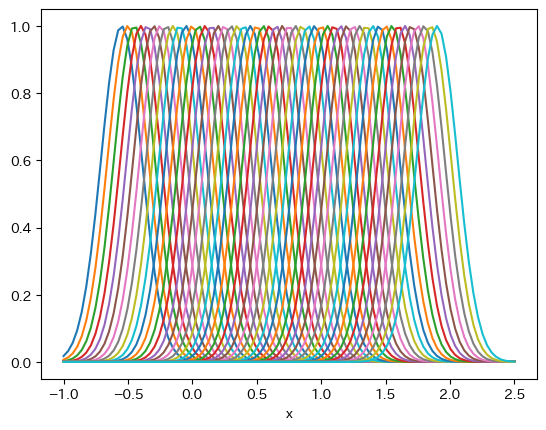

In [7]:
df.plot(x= "x", y = sample_columns, legend=False);

In [8]:
def rbf_func(x, theta):
    tmp_x = - delta * (jnp.arange(len(theta))) + x + 0.5
    rbfs = rbf(tmp_x, beta)
    return jnp.sum(theta * rbfs)

In [9]:
@partial(jax.jit, static_argnums=1)
def Fit(T, N, theta):
    dx = T/N
    J = 0
    for i in range(N):
        u = rbf_func((i+1)*dx,  theta)
        # print(u)
        f = jnp.exp(-5*(i+1)*dx)*jnp.sin(5*(i+1)*dx)
        J += (u - f)**2
    return J

# 勾配降下法（手書き）版

In [10]:
def train(T, N, theta, lr):
    new_theta = theta
    for i in trange(train_itr, leave=False):
        gs = jax.grad(Fit, argnums=-1)(T, N, new_theta)
        new_theta -= lr * gs
        # print(new_theta, gs)
        loss = Fit(T, N, new_theta)
        print("\r"+"\rloss:{}".format(loss), end=" ")
    return new_theta

In [11]:
N = 100
T = 1.0
theta_train = np.ones(50)
train_itr = 500

new_theta = train(T, N, theta_train, 0.003)

  0%|          | 0/500 [00:00<?, ?it/s]

loss:0.1579113006591797  

In [12]:
df = pd.DataFrame()
xs = np.linspace(0,1,100)

init = []
trained = []
exact = []
dx = T/N
for x in xs:
    init.append(rbf_func(x, theta_train))
    trained.append(rbf_func(x, new_theta))
    exact.append(np.exp(-5*x)*np.sin(5*x))
df["x"] = xs
df["init_RBF"] = init
df["trained_RBF"] = trained
df["trained_RBF"] = df["trained_RBF"].astype(float)
df["Exact"] = exact

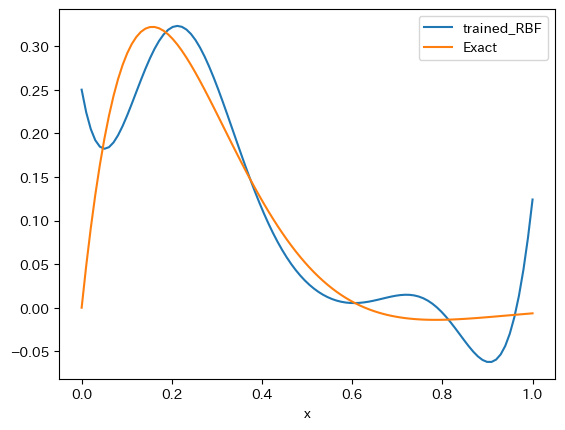

In [13]:
df.plot("x", ["trained_RBF", "Exact"]);#, "init_RBF"])

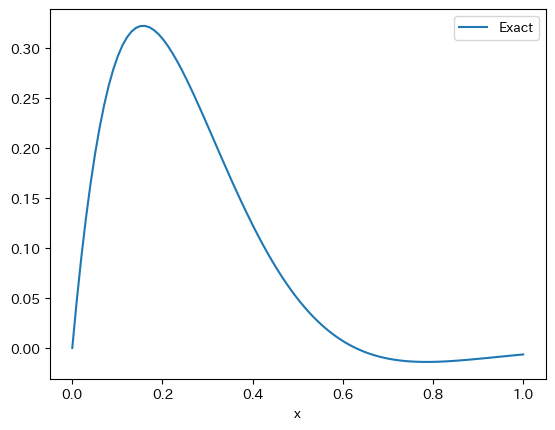

In [14]:
df.plot("x", ["init_RBF", "Exact"]);

# Adam版

In [15]:
@jax.jit
def step(step, opt_state):
    value, grads = jax.value_and_grad(Fit, argnums=-1)(T, N, get_params(opt_state))
    opt_state = opt_update(step, grads, opt_state)
    return value, opt_state

In [16]:
opt_init, opt_update, get_params = optimizers.adam(1.0)
opt_state = opt_init(theta_train)

train_itr = 250
for i in trange(train_itr, leave = False):
    loss, opt_state = step(i, opt_state)
    print("\r"+"\rloss:{}".format(loss), end=" ")


  0%|          | 0/250 [00:00<?, ?it/s]

loss:0.00025464408099651337 

In [17]:
df = pd.DataFrame()
xs = np.linspace(0,1,100)

init = []
trained = []
exact = []
dx = T/N
for x in xs:
    init.append(rbf_func(x, theta_train))
    trained.append(rbf_func(x, get_params(opt_state)))
    exact.append(np.exp(-5*x)*np.sin(5*x))
df["x"] = xs
df["init_RBF"] = init
df["trained_RBF"] = trained
df["trained_RBF"] = df["trained_RBF"].astype(float)
df["Exact"] = exact

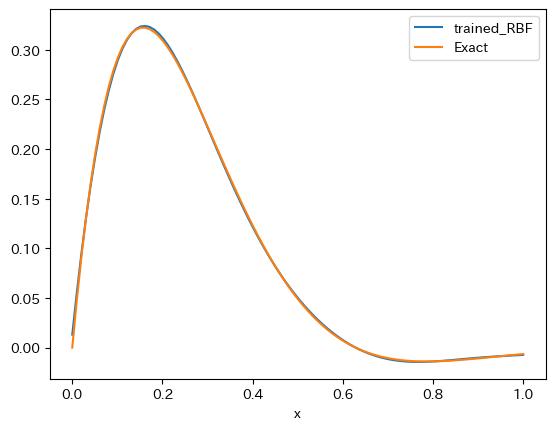

In [18]:
df.plot("x", ["trained_RBF", "Exact"]);